In [81]:
import numpy as numpy
from scipy import stats
import pandas as pd

from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 100)
sns.set_style("whitegrid")

# Data Loading

In [82]:
path = "./ENB2012_data.xlsx" 
df = pd.read_excel(path)
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [83]:
df.columns = [
    "Relative_Compactness",
    "Surface_Area",
    "Wall_Area",
    "Roof_Area",
    "Overall_Height",
    "Orientation",
    "Glazing_Area",
    "Glazing_Area_Distribution",
    "Heating_Load",
    "Cooling_Load",
]
df.head()

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


# Preprocessing

In [84]:
df.describe()

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307195,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090204,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


In [85]:
# Orientation 변수는 2, 3, 4, 5의 네 가지 값(범주형 변수)으로 구성되어 있으며, 각 값이 동일한 빈도(192개)를 갖는다.
df["Orientation"].value_counts()

Orientation
2    192
3    192
4    192
5    192
Name: count, dtype: int64

In [86]:
# Glazing_Area_Distribution 변수는 0부터 5까지 총 6개의 범주로 구성되어 있으며, 이 중 1~5번 범주는 각각 144개의 데이터를 가지고 있어 균형 잡힌 분포를 보인다.  
# 반면, 0번 범주는 단 48개로 상대적으로 매우 적은 수를 차지하고 있으며, 이는 모델 학습 시 해당 범주에 대한 정보가 부족할 수 있음을 시사한다.  
# 특히 0번은 유리창이 전혀 없는 구조를 나타낼 가능성이 있어, 분석 시 주의 깊게 해석할 필요가 있다.
df["Glazing_Area_Distribution"].value_counts()

Glazing_Area_Distribution
1    144
2    144
3    144
4    144
5    144
0     48
Name: count, dtype: int64

# EDA: 건물 특성과 에너지 효율성 간의 관계

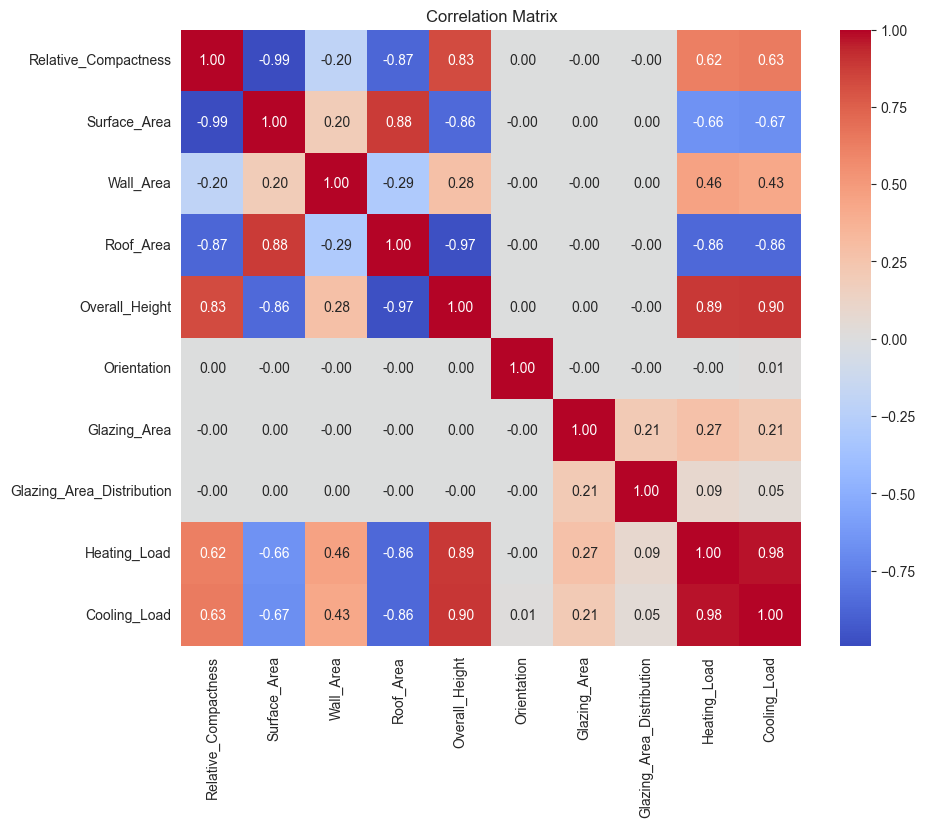

In [87]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

#### 상관관계 분석 목적
- 건물의 구조적 특성과 에너지 효율성 간의 관계를 파악하여, 향후 예측 모델에서 중요한 독립변수를 선별하기 위함이다.

#### 상관관계 히트맵 결과
- Y변수 (`Heating_Load`, `Cooling_Load`)와의 상관관계 기준 주요 변수:

| Feature                  | Heating_Load | Cooling_Load | Interpretation           |
|--------------------------|--------------|---------------|--------------------------|
| Relative_Compactness     | **+0.62**     | **+0.63**      | 다소 강한 양의 상관관계 |
| Surface_Area             | **−0.66**     | **−0.67**      | 다소 강한 음의 상관관계 |
| Wall_Area                | +0.46         | +0.43          | 중간 정도의 양의 상관관계 |
| Roof_Area                | **−0.86**     | **−0.86**      | 매우 강한 음의 상관관계 |
| Overall_Height           | **+0.89**     | **+0.90**      | 매우 강한 양의 상관관계 |

#### 영향이 적은 변수들
- `Orientation`, `Glazing_Area`, `Glazing_Area_Distribution`는 두 Y값과의 상관계수가 거의 0에 가까워 예측 모델에서의 영향력이 낮을 것으로 판단된다.

#### 정리
- **Overall_Height**: 난방/냉방 부하에 가장 큰 양의 영향을 미치는 변수
- **Roof_Area**: 두 target 모두에 음의 영향을 주는 특성
- **Relative_Compactness**: 부하 예측에 안정적이고 의미 있는 영향력을 보인다.

/Users/dobby/.pyenv/versions/3.11.8/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/dobby/.pyenv/versions/3.11.8/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 52992 (\N{HANGUL SYLLABLE KE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/dobby/.pyenv/versions/3.11.8/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/dobby/.pyenv/versions/3.11.8/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47553 (\N{HANGUL SYLLABLE RING}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/dobby/.pyenv/versions/3.11.8/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54980 (\N{HANGUL 

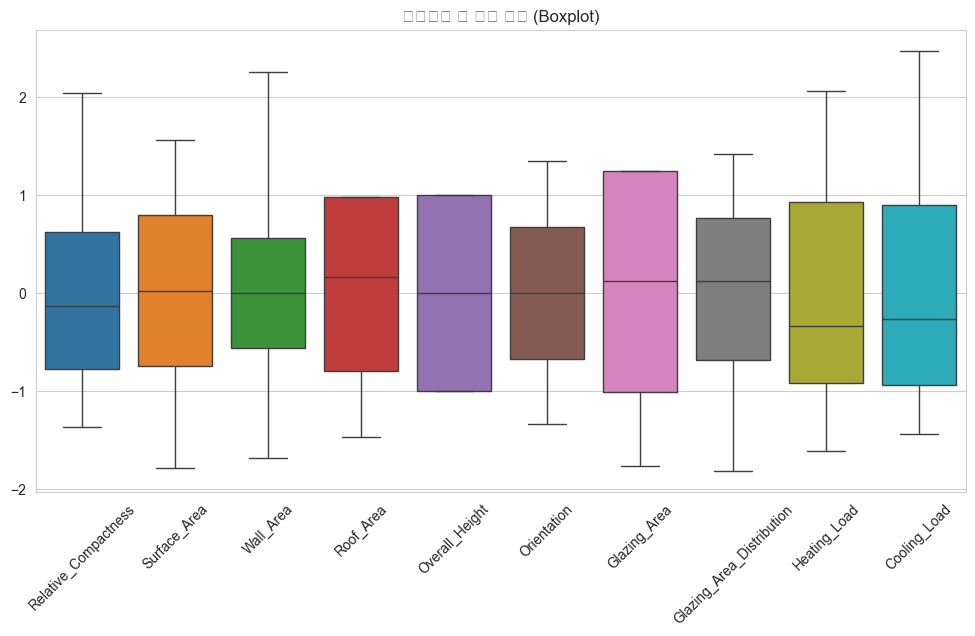

In [ ]:
# 표준화 전 변수들의 단위 차이를 제거하고 분포를 보기 위한 boxplot
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

plt.figure(figsize=(12, 6))
sns.boxplot(df_scaled)
plt.xticks(rotation=45)
plt.title("스케일링 후 변수 분포 (Boxplot)")
plt.show()

### Boxplot을 통한 변수 분포 확인

- 원본 데이터를 그대로 boxplot으로 시각화하면 변수 간 스케일 차이 때문에 대부분의 변수가 0 근처에 눌려 보이게 된다.
- 이를 해결하기 위해 `StandardScaler`를 적용하여 각 변수의 평균과 분산을 정규화한 후 시각화하였다.
- 스케일링 후 boxplot에서는 이상치와 분포의 왜곡 여부를 변수별로 직관적으로 파악할 수 있다.

<Figure size 1200x1000 with 0 Axes>

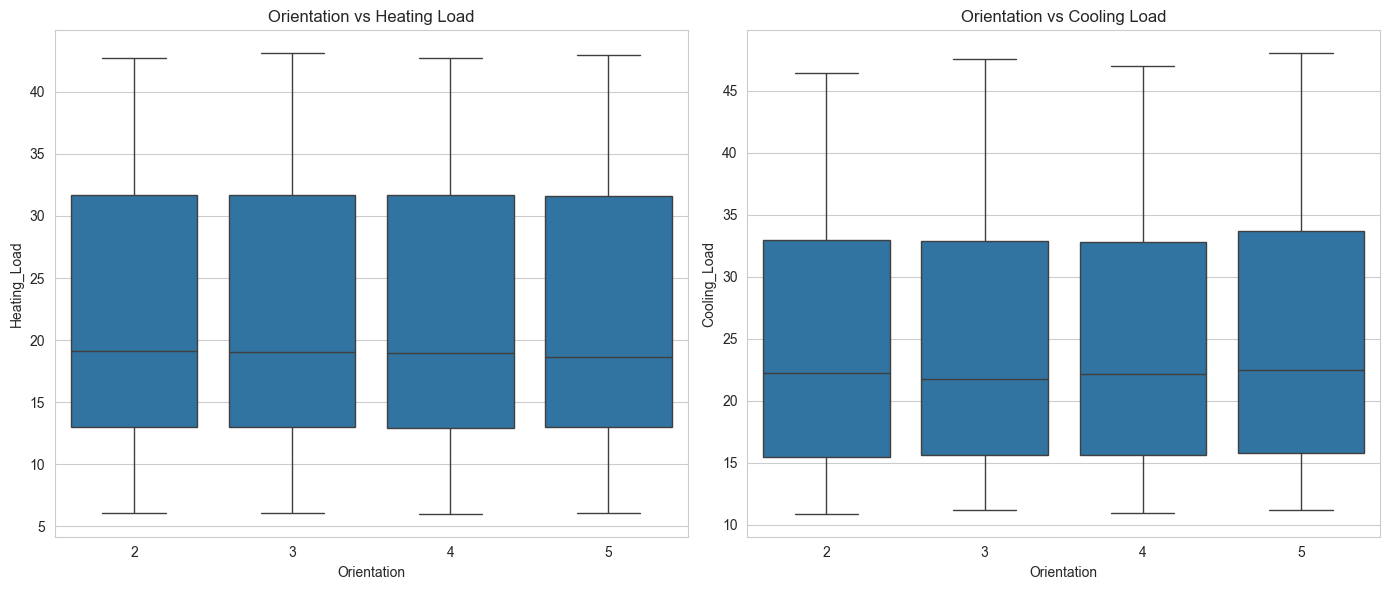

In [88]:
# 타겟별 Boxplot (범주형 vs 연속형)
# 특정 범주형 변수에 따라 에너지 부하가 어떻게 다른지 비교
plt.figure(figsize=(12, 10))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
sns.boxplot(data=df, x="Orientation", y="Heating_Load", ax=ax[0])
ax[0].set_title("Orientation vs Heating Load")
sns.boxplot(data=df, x="Orientation", y="Cooling_Load", ax=ax[1])
ax[1].set_title("Orientation vs Cooling Load")
plt.tight_layout()
plt.show()

- Orientation에 따른 Heating_Load와 Cooling_Load 분포를 비교한 결과, 방향에 따른 부하 차이는 크지 않음을 확인할 수 있다.
- 이는 상관계수 분석 결과에서도 Orientation 변수와 타겟 변수 간 상관이 거의 없었던 것과 일치한다.

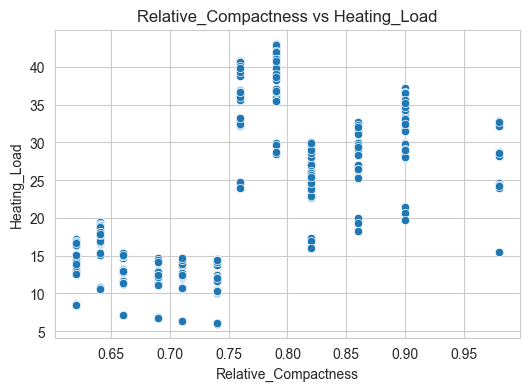

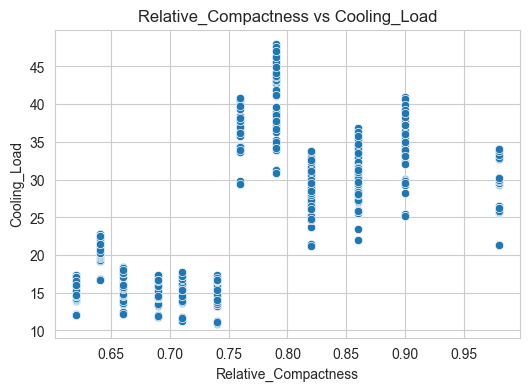

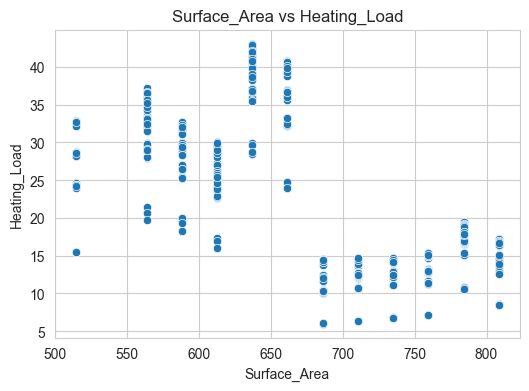

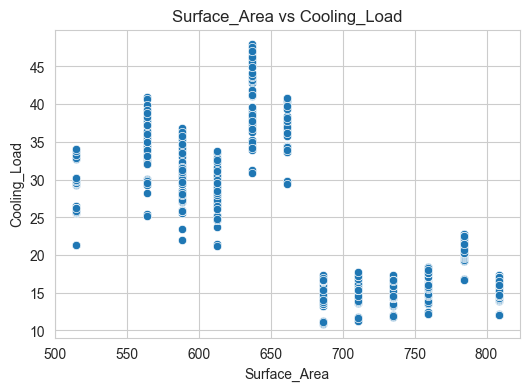

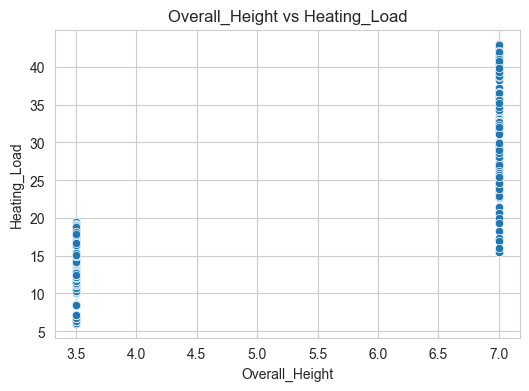

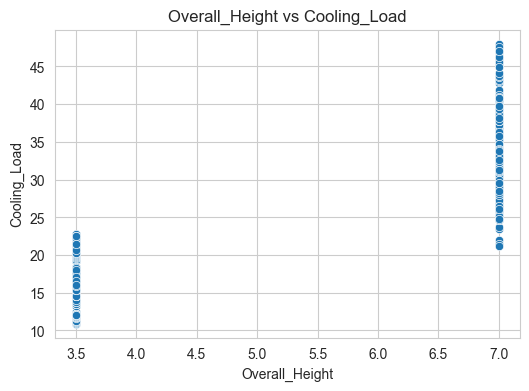

In [92]:
# 타겟별 Scatter Plot (연속형 vs 타겟)
# 중요 변수들과 타겟(난방/냉방 부하) 간의 관계 시각화
# 해당 변수(key_features)들은 Heating_Load, Cooling_Load와의 상관계수 절댓값이 0.6 이상으로, 부하(Load)에 의미 있는 영향을 준다.

key_features = ["Relative_Compactness", "Surface_Area", "Overall_Height"]
target_vars = ["Heating_Load", "Cooling_Load"]

for feature in key_features:
    for target in target_vars:
        plt.figure(figsize=(6, 4))
        sns.scatterplot(data=df, x=feature, y=target)
        plt.title(f"{feature} vs {target}")
        plt.show()

- Relative_Compactness는 Heating_Load 및 Cooling_Load와 모두 강한 음의 선형 관계를 보인다.
- Overall_Height는 두 타겟 변수와 양의 선형 관계를 나타낸다.
- 이는 상관계수 히트맵에서 관찰된 관계를 시각적으로도 확인할 수 있다.

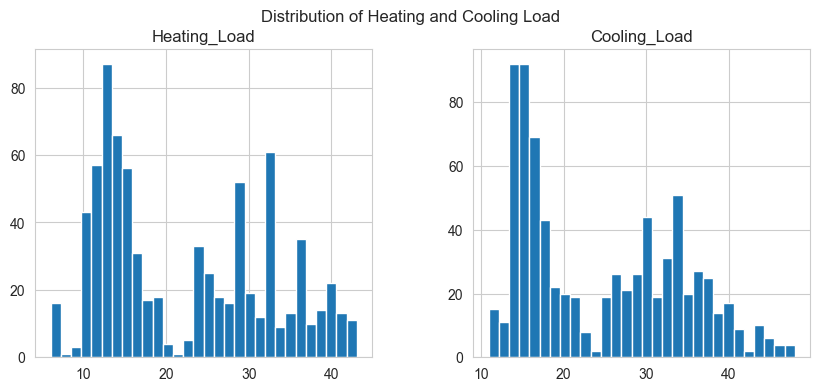

In [70]:
# 히스토그램 또는 KDE (분포 시각화)
# 변수 분포를 확인하여 왜도(Skewness)나 이상치 판단
df[["Heating_Load", "Cooling_Load"]].hist(bins=30, figsize=(10, 4))
plt.suptitle("Distribution of Heating and Cooling Load")
plt.show()

### 타겟 변수 분포 해석

#### Heating_Load

- Heating_Load 변수는 주로 **10~20 사이**에 분포되어 있으며, 이 구간에 데이터가 가장 밀집되어 있다.  
- 그러나 30 이상의 값들도 일정 비율 존재하여, 전체적으로 **오른쪽 꼬리가 긴 비대칭 분포**를 보인다.  
- 이는 해당 변수의 분포가 **우측 왜도(Positive Skewness)**를 가지는 것으로 해석할 수 있다.  
- 따라서 Heating_Load는 **정규분포를 따르지 않으며**, 이상값(outlier)의 존재 가능성도 고려해야 한다.

#### Cooling_Load

- Cooling_Load 변수 역시 **10~20 사이**에 데이터가 집중되어 있으며, Heating_Load와 유사한 분포 경향을 보인다.  
- 하지만 Heating_Load보다 전체적으로 **분산이 더 크며**, **30~40 사이**의 구간에도 빈도수가 많은 특징을 가진다.  
- 분포 형태는 **이중 봉우리(bimodal)**와 유사한 형태로 해석될 수 있으며, 약한 우측 왜도 또한 존재한다.  
- Cooling_Load 또한 정규분포를 완전히 따르지 않으며, **비대칭성과 분산 특성**을 고려하여 회귀 모델을 구성할 필요가 있다.

# Modeling

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

In [41]:
# 변수 분리
X = df.drop(columns=["Heating_Load", "Cooling_Load"])
Y1 = df["Heating_Load"]
Y2 = df["Cooling_Load"]

In [ ]:
# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# train/test 분리
# X, Y1, Y2를 모두 train/test로 나누기
X_train, X_test, Y1_train, Y1_test, Y2_train, Y2_test = train_test_split(
    X_scaled, Y1, Y2, test_size=0.2, random_state=42
)

In [48]:
# 4. Model 1: Heating_Load
model_Y1 = LinearRegression()
model_Y1.fit(X_train, Y1_train)
Y1_pred_train = model_Y1.predict(X_train)
Y1_pred_test = model_Y1.predict(X_test)

In [ ]:
# 5. Model 2: Cooling_Load (Chained)
X_train_chained = np.hstack([X_train, Y1_pred_train.reshape(-1, 1)])
X_test_chained = np.hstack([X_test, Y1_pred_test.reshape(-1, 1)])

model_Y2 = LinearRegression()
model_Y2.fit(X_train_chained, Y2_train)
Y2_pred_test = model_Y2.predict(X_test_chained)

In [60]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Heating_Load 평가
print("Heating_Load 모델 성능")
print(f"Train R²: {r2_score(Y1_train, Y1_pred_train):.3f}")
print(f"Train MAE: {mean_absolute_error(Y1_train, Y1_pred_train):.2f}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(Y1_train, Y1_pred_train)):.2f}")
print(f"Train MAPE: {mean_absolute_percentage_error(Y1_train, Y1_pred_train):.2f}%")

print(f"Test R²: {r2_score(Y1_test, Y1_pred_test):.3f}")
print(f"Test MAE: {mean_absolute_error(Y1_test, Y1_pred_test):.2f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(Y1_test, Y1_pred_test)):.2f}")
print(f"Test MAPE: {mean_absolute_percentage_error(Y1_test, Y1_pred_test):.2f}%")

Heating_Load 모델 성능
Train R²: 0.916
Train MAE: 2.06
Train RMSE: 2.91
Train MAPE: 9.68%
Test R²: 0.912
Test MAE: 2.18
Test RMSE: 3.04
Test MAPE: 10.15%


In [61]:
# Cooling_Load 평가
print("Cooling_Load 모델 성능")
Y2_pred_train = model_Y2.predict(X_train_chained)  # 예측값 저장

print(f"Train R²: {r2_score(Y2_train, Y2_pred_train):.3f}")
print(f"Train MAE: {mean_absolute_error(Y2_train, Y2_pred_train):.2f}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(Y2_train, Y2_pred_train)):.2f}")
print(f"Train MAPE: {mean_absolute_percentage_error(Y2_train, Y2_pred_train):.2f}%")

print(f"Test R²: {r2_score(Y2_test, y2_pred_test):.3f}")
print(f"Test MAE: {mean_absolute_error(Y2_test, y2_pred_test):.2f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(Y2_test, y2_pred_test)):.2f}")
print(f"Test MAPE: {mean_absolute_percentage_error(Y2_test, y2_pred_test):.2f}%")

Cooling_Load 모델 성능
Train R²: 0.887
Train MAE: 2.25
Train RMSE: 3.19
Train MAPE: 8.98%
Test R²: 0.894
Test MAE: 2.21
Test RMSE: 3.13
Test MAPE: 8.56%


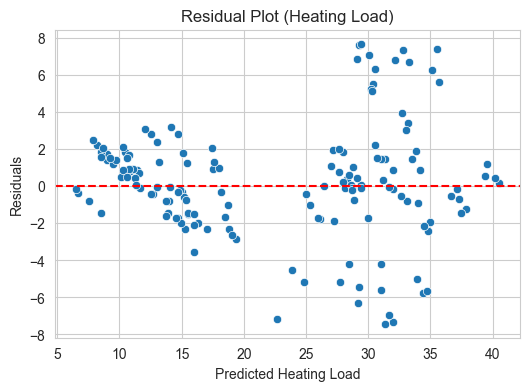

In [ ]:
# 잔차(residual) 플롯 (모델 평가)
# 모델이 특정 구간에서 예측을 과소하거나 과대하는 경향이 있는지 보기 위해
residuals = Y1_test - Y1_pred_test
plt.figure(figsize=(6, 4))
sns.scatterplot(x=Y1_pred_test, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Heating Load")
plt.ylabel("Residuals")
plt.title("Residual Plot (Heating Load)")
plt.show()

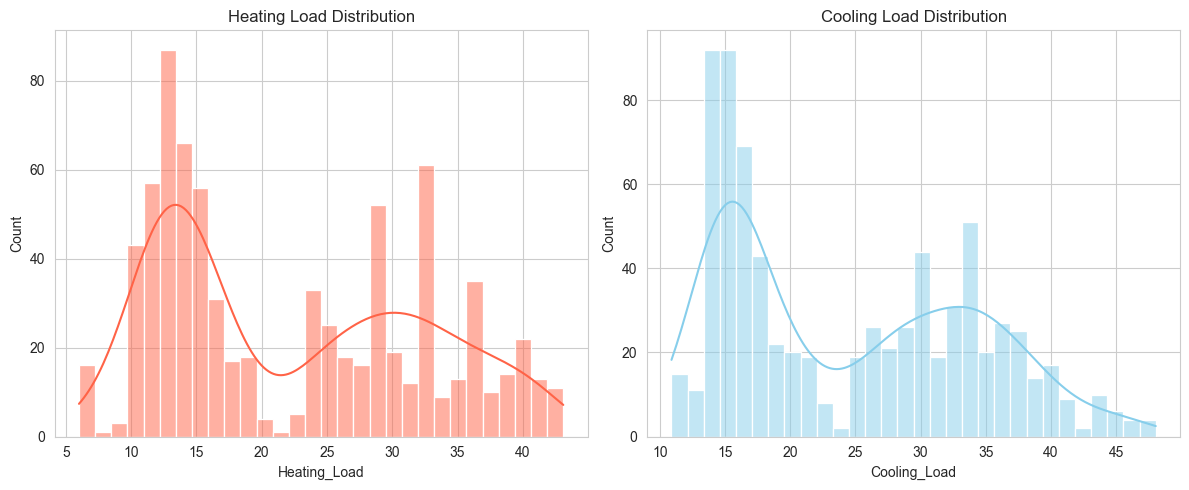

In [72]:
# 히스토그램으로 Heating_Load와 Cooling_Load 분포 확인
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df["Heating_Load"], kde=True, bins=30, color="tomato")
plt.title("Heating Load Distribution")

plt.subplot(1, 2, 2)
sns.histplot(df["Cooling_Load"], kde=True, bins=30, color="skyblue")
plt.title("Cooling Load Distribution")

plt.tight_layout()
plt.show()

### 타겟 변수 분포 확인 (히스토그램)

난방 부하(Heating Load)와 냉방 부하(Cooling Load)의 분포를 시각화한 결과,  
두 변수 모두 비교적 정규 분포에 가까운 형태를 보이며, 모델링에 적합한 분포 특성을 가짐을 확인할 수 있다.  
다만 Heating Load의 경우 약간의 오른쪽 꼬리(tail)가 존재한다.

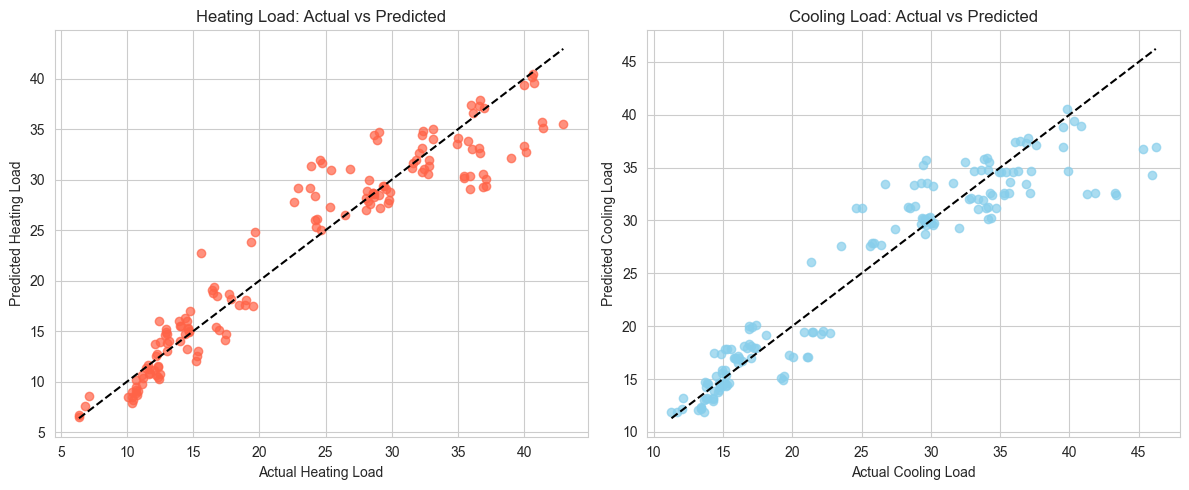

In [74]:
# 예측값 vs 실제값 비교 (산점도 plot)
plt.figure(figsize=(12, 5))

# Heating_Load
plt.subplot(1, 2, 1)
plt.scatter(Y1_test, Y1_pred_test, alpha=0.7, color="tomato")
plt.xlabel("Actual Heating Load")
plt.ylabel("Predicted Heating Load")
plt.title("Heating Load: Actual vs Predicted")
plt.plot([Y1_test.min(), Y1_test.max()], [Y1_test.min(), Y1_test.max()], 'k--')

# Cooling_Load
plt.subplot(1, 2, 2)
plt.scatter(Y2_test, y2_pred_test, alpha=0.7, color="skyblue")
plt.xlabel("Actual Cooling Load")
plt.ylabel("Predicted Cooling Load")
plt.title("Cooling Load: Actual vs Predicted")
plt.plot([Y2_test.min(), Y2_test.max()], [Y2_test.min(), Y2_test.max()], 'k--')

plt.tight_layout()
plt.show()

### 예측값 vs 실제값 시각화

모델이 예측한 난방 및 냉방 부하 값과 실제 값을 산점도로 비교한 결과, 대부분의 점들이 기준선(y=x)에 근접해 있는 것을 확인할 수 있다.  
이는 모델이 타겟 값을 비교적 정확히 예측하고 있음을 의미한다.

## 모델 성능 평가

각 모델의 설명력(R²)과 오차(MAE, RMSE, MAPE)를 기준으로 **난방 부하(Heating Load)**와 **냉방 부하(Cooling Load)** 예측 성능을 평가하였다.

#### 📌 평가 지표 설명
- **R² (결정계수)**: 모델이 실제값을 얼마나 잘 설명하는지 나타냄. 1에 가까울수록 성능이 우수함.
- **MAE (Mean Absolute Error)**: 평균 절대 오차. 값이 작을수록 정확한 예측을 의미함.
- **RMSE (Root Mean Squared Error)**: 제곱 평균 오차의 제곱근으로, 이상치에 민감함.
- **MAPE (Mean Absolute Percentage Error)**: 예측값이 실제값에 대해 평균적으로 몇 %의 오차를 가지는지 나타냄. 값이 작을수록 정확함.

---

### 모델 성능 요약

| Target         | 구분     | R²     | MAE   | RMSE  | MAPE (%) |
|----------------|----------|--------|-------|--------|-----------|
| Heating Load   | Train    | 0.916  | 2.06  | 2.91   | 9.68      |
|                | Test     | 0.912  | 2.18  | 3.04   | 10.15     |
| Cooling Load   | Train    | 0.887  | 2.25  | 3.19   | 8.98      |
|                | Test     | 0.894  | 2.21  | 3.13   | 8.56      |
---

### 해석

- **Heating Load 예측 모델**은 R² 값이 높고 MAE, RMSE, MAPE 값이 낮아, **설명력과 예측 정확도 모두 우수**한 성능을 보임.
- **Cooling Load 예측 모델**은 **난방 부하 예측 결과를 추가 입력으로 사용한 Chained Prediction(연쇄 예측) 구조**를 적용하여, 두 목표 변수 간의 상관관계를 일부 반영할 수 있었음.
- 전반적으로 두 모델 모두 **회귀 기반 모델로서 안정적인 성능**을 보이며, 에너지 효율성 예측에 활용 가능함을 확인함.

# End of Documents